## **Quickstart Guide**

This guide covers a simple workflow to help you get started with twinLab. In this notebook, we will perform the following steps:

1. Upload a dataset to the twinLab cloud.
2. Use `Emulator.train` to train a surrogate model.
3. Use the emulator to make a prediction with `Emulator.predict`.
4. Visualise the results and their uncertainty.

In [1]:
# Third-party imports
import numpy as np
import pandas as pd

# Project imports
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.5.0
          Server      : https://twinlab.digilab.co.uk/mead
          Environment : /Users/mead/digiLab/twinLab-Tutorials/.env



### **Set your API Key**

If you don't already have one, please vist [https://www.digilab.co.uk/contact](https://www.digilab.co.uk/contact). For security, we normally recommend performing this step with a `.env` file or `secrets`.


In [2]:
tl.set_api_key("REPLACE_THIS_WITH_YOUR_API_KEY")

### **1. Upload a dataset to twinLab**

Your dataset must be presented as a `pandas.DataFrame` object, or a filepath which points to a `csv` file that can be parsed to a `pandas.DataFrame` object. **The dataset must be formatted with clearly labelled columns.** In `twinlab`, data is expected to be in column-feature format, meaning each row represents a single data sample, and each column represents a data feature, also known as a parameter.

`twinLab` contains a `Dataset` class with attributes and methods to process, view and summarise the dataset. Datasets must be created with an `id` which is used to access them. The dataset can be uploaded using the `upload` method.

In twinLab, we provide some example datasets to helps user get started (see `tl.list_example_datasets` for a list). Here we use the example `quickstart` dataset, which has a single input (feature/predictor/parameter) variable `x` and a single output (response) variable `y`.


In [3]:
# Download the example dataset
df = tl.load_example_dataset("quickstart")

# Check the dataframe before uploading
display(df)

# Intialise a Dataset object and give it a name
dataset = tl.Dataset("quickstart")

# Upload the dataset, passing in the dataframe
dataset.upload(df)

,x,y
0,0.696469,-0.817374
1,0.286139,0.887656
2,0.226851,0.921553
3,0.551315,-0.326334
4,0.719469,-0.832518
5,0.423106,0.400669
6,0.980764,-0.164966
7,0.684830,-0.960764
8,0.480932,0.340115
9,0.392118,0.845795


/Users/mead/Library/Caches/pypoetry/virtualenvs/twinlab-demos-I0xPLdGj-py3.11/lib/python3.11/site-packages/twinlab/utils.py:89: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not df.applymap(lambda x: isinstance(x, (int, float))).all().all():


### **2. Train an emulator**

The `Emulator` class is used to train and implement your surrogate models. As with datasets, an `id` is defined, which is a unique ID under which your emulator will be saved as in the cloud.

When training an emulator, optional arguments are passed in using a `TrainParams` object. `TrainParams` contains parameters you can tweak when training your model - you can find the defaults in the documentation.

To train the emulator we use the `Emulator.train` method, passing in the `TrainParams` object as an argument.


In [4]:
# Initialise emulator
emulator = tl.Emulator("quickstart-model")

# Define the training parameters for the emulator.
# For example, here we set the train_test_ratio to 1, meaning that the entire dataset will be used for training.
params = tl.TrainParams(train_test_ratio=1.)

# Train the mulator using the train method
emulator.train(
    dataset=dataset,
    inputs=["x"],
    outputs=["y"],
    params=params
    )

### **3. Make Predictions using the Trained Emulator**

The surrogate model is now trained and saved to the cloud under the `id` specified above. It can now be used to make predictions.

You'll need a dataset of inputs for which you want to find the corresponding outputs. Ensure that this is a `pandas.DataFrame` object. Then call `Emulator.predict`, with the evaluation dataset as the keyword argument.


In [5]:
# We'll define some example inputs for the dataset
x_predict = np.linspace(0, 1, 11)

# And convert them to a DataFrame
df_predict = pd.DataFrame({"x": x_predict})

# Now we'll predict the results.
# This returns a tuple of two dataframes:
# 1. The mean prediction corresponding to each input
# 2. The standard deviation corresponding to each input
predictions_mean, predictions_std = emulator.predict(df_predict)

# Write the predictions to the screen
print("Mean predictions:")
display(predictions_mean)
print("Standard deviation predictions:")
display(predictions_std)

Mean predictions:


,y
0,0.618116
1,0.766788
2,0.891405
3,0.908986
4,0.669546
5,0.090804
6,-0.567991
7,-0.863546
8,-0.733036
9,-0.420330


Standard deviation predictions:


,y
0,0.653885
1,0.424600
2,0.202528
3,0.161307
4,0.153866
5,0.156232
6,0.170339
7,0.149920
8,0.233575
9,0.243088


In [6]:
# Let's merge these into a single dataframe...
result_df = pd.concat([df_predict, predictions_mean, predictions_std], axis="columns")

# ...and rename the columns to make the contents of the output clear
result_df.columns = ["x to predict", "predicted mean y", "predicted std y"]

# Let's have a look!
display(result_df)

,x to predict,predicted mean y,predicted std y
0,0.0,0.618116,0.653885
1,0.1,0.766788,0.424600
2,0.2,0.891405,0.202528
3,0.3,0.908986,0.161307
4,0.4,0.669546,0.153866
5,0.5,0.090804,0.156232
6,0.6,-0.567991,0.170339
7,0.7,-0.863546,0.149920
8,0.8,-0.733036,0.233575
9,0.9,-0.420330,0.243088


### **4. Viewing the Results**

`Emulator.predict` outputs mean values for each input and their standard deviation; this gives the abilty to nicely visualise the uncertainty in results, using `Emulator.plot`


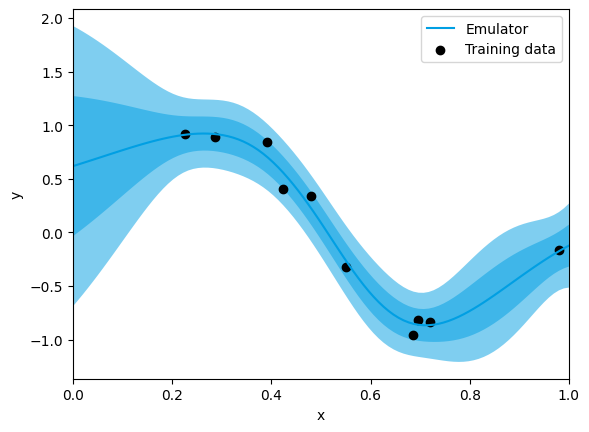

In [7]:
# Plot results
plt = emulator.plot(
    x_axis="x",
    y_axis="y",
    x_lim=(0, 1.0)
)
plt.scatter(df["x"], df["y"], color="black", label="Training data")
plt.legend()
plt.show()

### **Deleting datasets and campaigns**

You can delete your datasets and emulators. Please be aware that this is permanent. Always consider keeping your data backed-up. `Emulator.delete` and `Dataset.delete` delete the emulator and the dataset respectively.


In [8]:
# Delete the emulator
emulator.delete()

# Delete the dataset
dataset.delete()